
# Predicting cryptocurrency prices using AML Forecasting Toolkit

## Summary
This notebook demonstrates how to use the Azure Machine Learning (AML) Forecasting Toolkit (FTK) to forecast the value of crypte-currencies. The data we use is the [Kaggle Every Cryptocurrency Daily Market Price data](https://www.kaggle.com/jessevent/all-crypto-currencies/data). The following model development and deployment steps are implemented
* Data Ingestion: Load the data as `TimeSeriesDataFrame`, a time series data structure provided by FTK.
* Feature Engineering: Create features based on aggregates over given time spans.
* Model Training and Selection: Compare the performance of naive, seasonal naive, and ARIMA, and choose the one with the best performance.
* Model Deployment: Deploy the model pipeline via Azure Machine Learning to be consumed as a web service.

## Prerequisites
To use the deployment feature, we need to run this notebook within Azure Machine Learning.

For data processing and model development only, we can run the notebook outside of Azure Machine Learning.

Follow the instructions below to install the FTK in AML and get prepared for deployment. 

1. Create an Azure Machine Learning Experimentation account, install AML Workbench, and create an AML project following [this documentation](https://docs.microsoft.com/en-us/azure/machine-learning/preview/quickstart-installation). 
2. Install Docker. During installation if there are any hyper-v related issues on Windows, see [this link](https://blogs.technet.microsoft.com/canitpro/2015/09/08/step-by-step-enabling-hyper-v-for-use-on-windows-10/).
3. Download `kubectl.exe` from [here](https://storage.googleapis.com/kubernetes-release/release/v1.9.2/bin/windows/amd64/kubectl.exe) and put it under a directory that's in the system Path, e.g. `C:\users\willsmith\bin\`.
4. Start AML Workbench **as Administrator**. Open an existing project or create a new one, then navigate to *File -> Open Command Prompt*.
6. Follow the environment setup instructions from our [dogfood page](https://microsoft.sharepoint.com/teams/forecastpackagedogfood/SitePages/Home.aspx).
7. To open a jupyter notebook in the browser, run ```az ml notebook start``` from the AML command prompt *after* activating the FTK conda environment. 

# Part 1
## Import Packages

We begin by importing the relevant packages, including the FTK packages we learn to use throughout this course.

In [5]:
import sys
# for confirming that the FTK conda env is being used
print(sys.executable)

# faster autocomplete
%config Completer.use_jedi = False

# for putting visualizations inside the notebook
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# for being able to print more data
pd.set_option('display.max_rows', 1000)

from ftk.dataframets import TimeSeriesDataFrame
from ftk.dataframeforecast import ForecastDataFrame
from ftk.pipeline import AzureMLForecastPipeline

from ftk.transforms.lagoperator import LagOperator
from ftk.transforms.rollingwindow import RollingWindow
from ftk.transforms.tsimputer import TimeSeriesImputer

from ftk.models.arima import Arima
from ftk.models.naive import SeasonalNaive, Naive

from ftk.operationalization.scorecontext import ScoreContext
from ftk.operationalization.deployment import AMLEnvironment, AMLDeployment

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\python.exe
Populating the interactive namespace from numpy and matplotlib


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlf

Our dataset is in `data/crypto-markets.csv`. Let's read and glance at the data.

In [6]:
data = pd.read_csv(os.path.join('data', 'crypto-markets.csv'), low_memory = False)
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


---

## Lab 1:

Let's ensure the column types are correct. We want `date` to be of type `datetime`, `open` to be `float` and `slug` to be `category`.

In [7]:
data['date'] = pd.to_datetime(data['date']).dt.date
data['open'] = data['open'].astype('float')
data['slug'] = data['slug'].astype('category')

Determine the number of rows.

In [8]:
data.shape

(702166, 13)

Check to make sure that the combination of `slug` and `date` uniquely identify each row of the data. This means we can later use `slug` as a "grain index".

In [9]:
data.loc[data.duplicated(['slug', 'date'])].size == 0

True

### END OF LAB

---

Let's create a list of the slugs in the data, starting with the one with the most number of data points and ending with the one with the least number.

In [10]:
byslug_date = data.groupby('slug')['date'].describe()
byslug_date['min_dt'] = data.groupby('slug')['date'].min()
byslug_date['max_dt'] = data.groupby('slug')['date'].max()
byslug_date.head()

,count,unique,top,freq,min_dt,max_dt
slug,,,,,,
0x,190,190,2018-01-12,1,2017-08-16,2018-02-21
1337coin,836,836,2018-02-06,1,2015-11-09,2018-02-21
2give,647,647,2018-02-06,1,2016-05-16,2018-02-21
300-token,212,212,2018-02-06,1,2017-07-25,2018-02-21
42-coin,1485,1485,2018-02-06,1,2014-01-14,2018-02-21


In [11]:
top_slugs = data.groupby('slug')['open'].count().sort_values(ascending = False).index.values
top_slugs

[litecoin, bitcoin, namecoin, novacoin, peercoin, ..., neurotoken, dadi, gems-protocol, republic-protocol, litecoin-cash]
Length: 1516
Categories (1516, object): [0x, 1337coin, 2give, 300-token, ..., zozocoin, zrcoin, zsecoin, zurcoin]

If we wanted to, we could begin by sampling the data and grabbing only the most important currencies, this can be helpful if we're just getting started and want to just get a feel for the data or if the data for the least important currencies is not very populated and can cause problems.

In [12]:
top_slugs_only = False
if top_slugs_only == True:
    data = data.loc[data['slug'].isin(top_slugs[:10])]
    data.slug = data.slug.cat.remove_unused_categories()
    
data.shape

(702166, 13)

Let's create a visualization showing the day by day change in the price of some of the top currencies. As the plot below shows, the trend is very different from currency to currency and no visible seasonality can be seen (although we could be wrong about this). However the plot below is not very useful because it is dominated by `bitcoin`, making it hard to see any trend for the other currencies.

Text(0,0.5,'unit price')

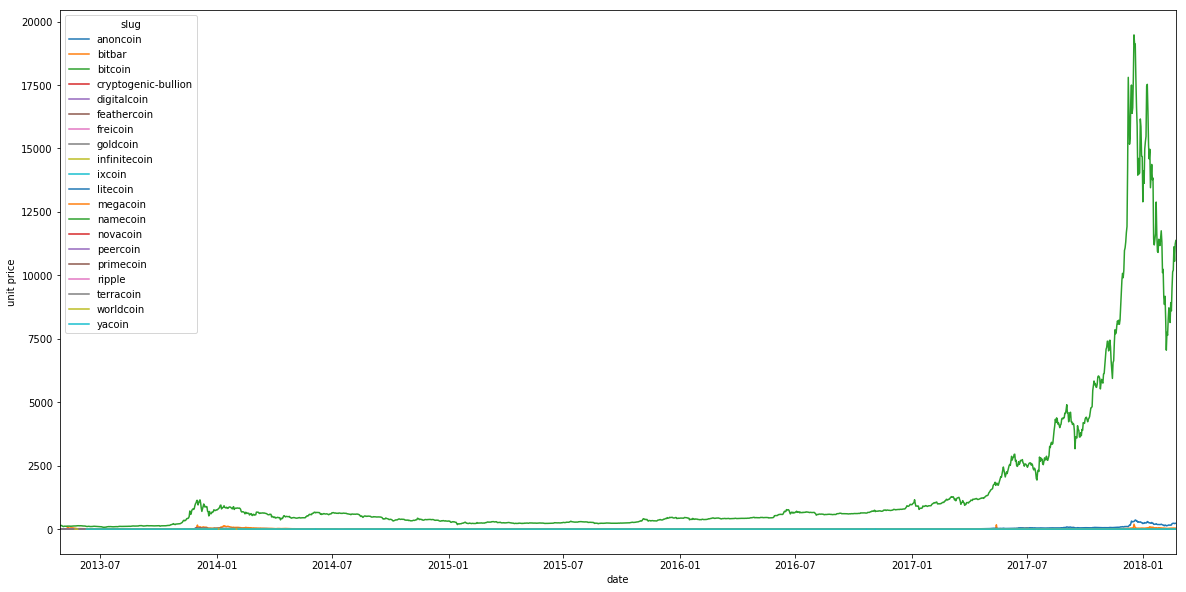

In [13]:
ax = data.loc[data['slug'].isin(top_slugs[:20])].groupby(['date', 'slug'])['open'].mean().unstack().plot()
ax.set_ylabel("unit price")

---

## Lab 2:

Remove the top three currencies (`bitcoin`, `litecoin` and `bitbar`) from the above plot and redraw the plot. By doing so we should be able to see more trends in the remaining currecies. Describe what you see, such as seasonality, similarities between currencies, etc.

Text(0,0.5,'unit price')

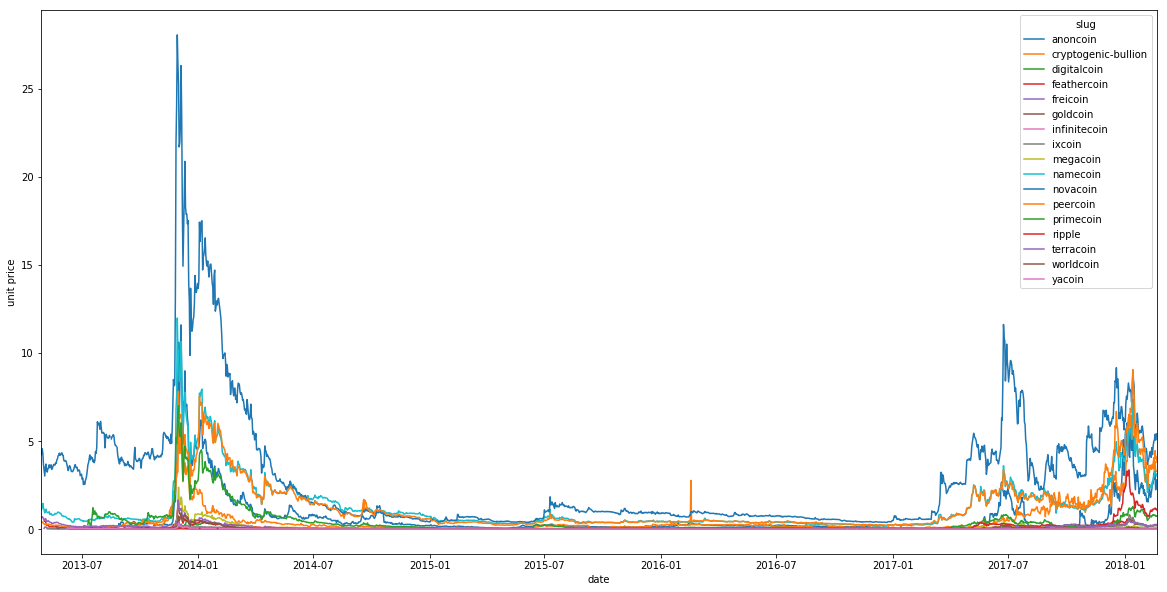

In [14]:
cats_to_remove = ['bitcoin', 'litecoin', 'bitbar']
ax = data.loc[data['slug'].isin(top_slugs[:20].remove_categories(cats_to_remove))].groupby(['date', 'slug'])['open'].mean().unstack().plot()
ax.set_ylabel("unit price")

### END OF LAB

---

# Part 2

There are a lot of other ways we can slice and dice the data, but in this tutorial we are interested in learning about the Forecasting package and how to use it. Our first step will be to create a times series data from the data above. This is done using the `TimeSeriesDataFrame` function.

The three important arguments to `TimeSeriesDataFrame` are `grain_colnames`, `time_colname`, and `group_colnames`:

 - `time_colnames` is simply the column in the data that stores the `datetime` information
 - `grain_colnames` lets us build a separate **series** for each category of a categorical column  (or combination of categories if multiple columns are specified)
 - `group_colnames` lets us build a separate **model** for each category of a categorical column (or combination of categories if multiple columns are specified)
 - `ts_value_colname` is the name of the column we want to run forecasts on
 
The distinction between `grain_colnames` and `group_colnames` is important. A categorical column can be a good candidate for `grain_colnames` if we expect that within each category the time series behave similarly and can be modeled using the same model. This is usually considered a conservative approach and can hurt prediction accuracy. If that case, we should list it under `group_colnames` so that each category is modeled differently (is allowed to have different parameters).

In [15]:
data_ts = TimeSeriesDataFrame(data, grain_colnames = ['slug'], time_colname = 'date', 
                              ts_value_colname = 'open', group_colnames = ['slug'])
data_ts.head()

,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,slug,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


Notice the the columns `date` and `slug` are now in bold. This means these columns now act as indexes for the data. Our data has a `MultiIndex` and each combination of these two columns is unique (otherwise the above command would have failed). Handling a `MultiIndex` column in `pandas` requires some care.

---

## Lab 3:

We can use the `ts_summary()` method of the time series data to get some relevant summary statistics that can help us identify certain trends and behaviors and offer hints as to how we should "clean" the data prior to proceeding further. Uncomment and execute the command below and examine the results. What are some important things to point out?

--------------------------------  Data Overview  ---------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 702166 entries, (2013-04-28 00:00:00, bitcoin) to (2018-01-06 00:00:00, ocow)
Data columns (total 11 columns):
symbol         702166 non-null object
name           702166 non-null object
ranknow        702166 non-null int64
open           702166 non-null float64
high           702166 non-null float64
low            702166 non-null float64
close          702166 non-null float64
volume         702166 non-null int64
market         702166 non-null int64
close_ratio    702166 non-null float64
spread         702166 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 61.7+ MB
--------------------------  Numerical Variable Summary  --------------------------
        ranknow       open       high        low      close         volume  \
count 702166.00  702166.00  702166.00  702166.00  702166.00      702166.00   
mean     734.56     269.6

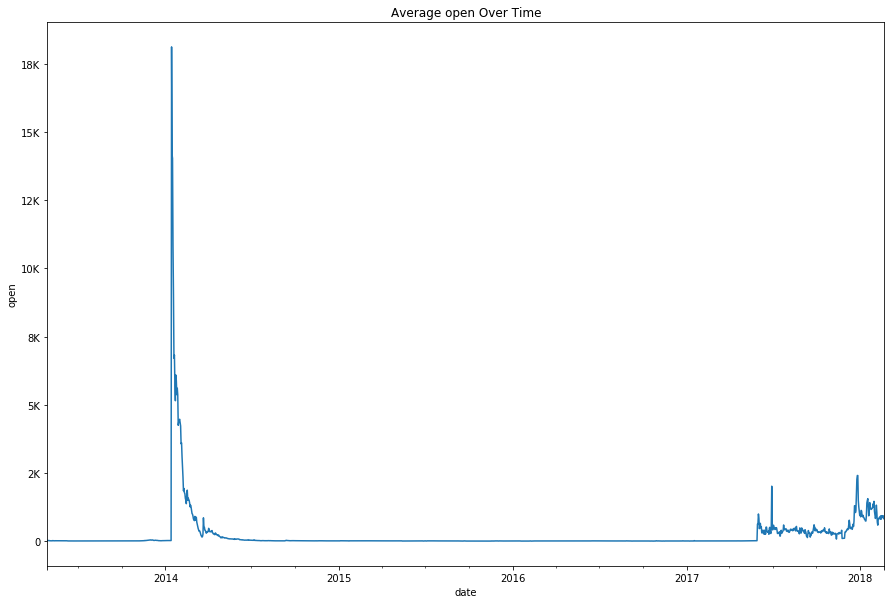

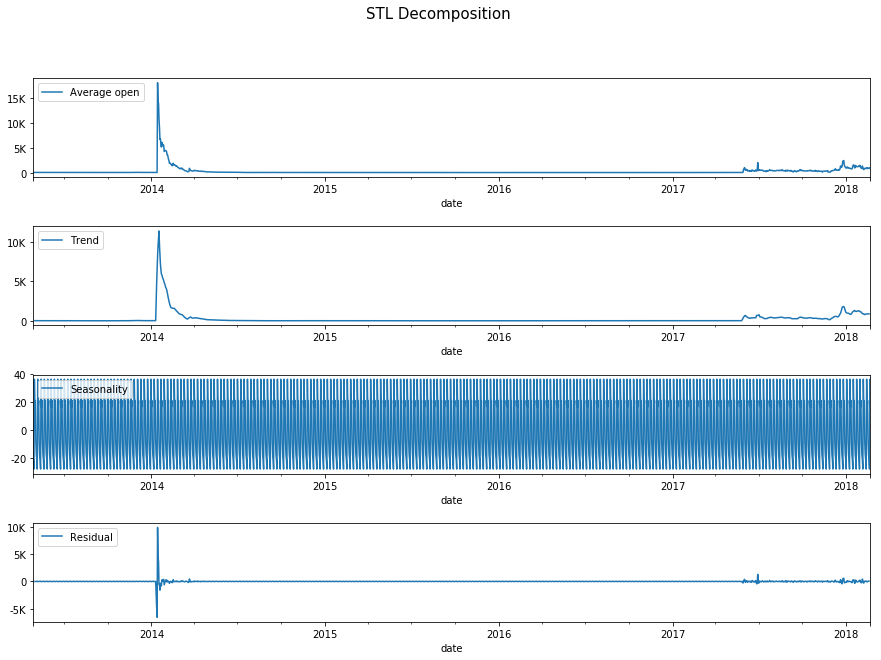

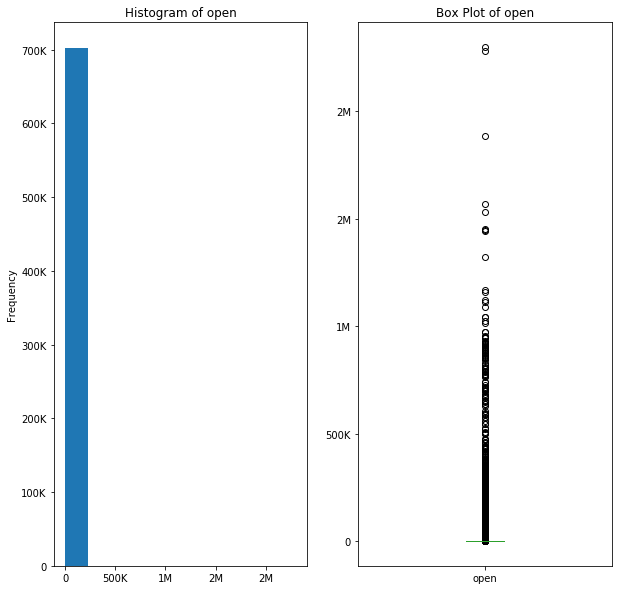

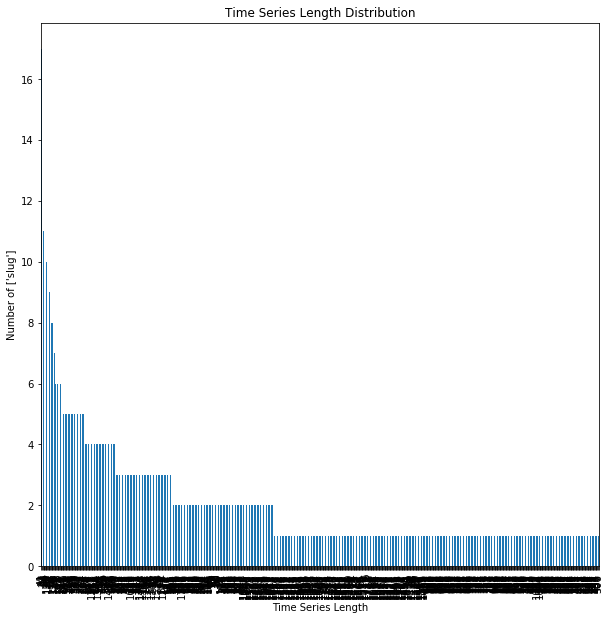

In [16]:
data_ts.ts_summary()

### END OF LAB

---

In order to model time series data, we need to be able to determine its frequency. In the results generated by the last command, we can see under `Time Series Summary` that we were able to infer a frequency of `D` (daily) for almost all the currencies except 14 of them. Of those 14, 12 were wrongly determined to have frequency `B` (business daily) and 2 currencies have unknown frequency. To know which currencies fall under any given frequency, we run the `get_frequency_dict` method.`

In [17]:
freq_to_slug = data_ts.get_frequency_dict()
{k:len(freq_to_slug[k]) for k in freq_to_slug.keys()}

{'B': 12, 'D': 1502, 'None': 2}

We can turn the above result into a `DataFrame` and join it back to `byslug_date`. The result is a table that shows useful information for each currency that could help us identify issues with the data.

In [18]:
# frequency distribution
slug_to_freq = pd.DataFrame([[v, k] for k, w in freq_to_slug.items() for v in w], 
                            columns = ['slug', 'frequency']).set_index('slug')

slug_to_freq = slug_to_freq.join(byslug_date, how = "left", lsuffix='_l', rsuffix='_r').rename(columns = {'count':'n_days'})
slug_to_freq.drop(['top', 'unique', 'freq'], inplace = True, axis=1)

slug_to_freq.head(10)

,frequency,n_days,min_dt,max_dt
slug,,,,
0x,D,190,2017-08-16,2018-02-21
1337coin,D,836,2015-11-09,2018-02-21
2give,D,647,2016-05-16,2018-02-21
300-token,D,212,2017-07-25,2018-02-21
42-coin,D,1485,2014-01-14,2018-02-21
808coin,D,576,2016-07-25,2018-02-21
8bit,D,1040,2015-04-18,2018-02-21
abjcoin,D,99,2017-11-10,2018-02-21
abncoin,D,397,2017-01-19,2018-02-21


## Lab 4

Add two new column to the above result: 

 - `n_days_max` should measure the number of days between the earliest and latest data points for each currency (`min_dt` and `max_dt`)
 - `n_days_missing` should find the number of days with no data point for each currency

In [19]:
slug_to_freq['n_days_max'] = (slug_to_freq['max_dt'] - slug_to_freq['min_dt']).dt.days + 1
slug_to_freq['n_days_missing'] = slug_to_freq['n_days_max'] - slug_to_freq['n_days']

Find the percentage of the currencies with no gaps in their data (i.e. no missing data from the earliest to the latest data point).

In [20]:
np.mean(slug_to_freq['n_days_max'] == slug_to_freq['n_days'])

0.5943271767810027

Find the percentage of currencies with fewer than 5 (not necessarily consecutive) days of gaps in data points. Hint: Start by finding the frequency table of `n_days_missing`.

In [21]:
n_days_miss_freq = np.unique(slug_to_freq['n_days_missing'], return_counts = True)
sum(n_days_miss_freq[1][:5])/sum(n_days_miss_freq[1])

0.6906332453825857

In [22]:
# slug_to_freq.groupby(['frequency', 'n_days'])['n_days'].count().sort_values(ascending = False).head()

In the time series data `data_ts`, create a column called `dow` that shows the day of the week each date falls under. 

In [23]:
data_ts['dow'] = data_ts.index.get_level_values(0).dayofweek.astype('object')

For one of the currencies whose frequency was inferred as 'B' (business daily), find the frequency distribution of each day of the week.

In [24]:
suspect_slugs = slug_to_freq.loc[slug_to_freq['frequency'] == 'B'].index.get_values()

data_ts.loc[data_ts.grain_index.isin(suspect_slugs[:])].groupby('dow').size()

dow
0    1413
1    1414
2    1418
3    1410
4    1409
5    1409
6    1411
dtype: int64

### END OF LAB

---

Given the issues we see in the data, we're going to to limit our data moving forward to a given a date range and our currencies to only those that have enough data points in the date range to make them good candidates for modeling.

In [25]:
start_dt = '2016-01-01'
end_dt = '2018-03-31'
max_num_slugs = 30

date_range = pd.date_range(start_dt, end = end_dt, freq='D')
which_slugs = (slug_to_freq['min_dt'] < np.datetime64('2015-12-01')) & (slug_to_freq['max_dt'] > np.datetime64('2017-12-01'))
sum(which_slugs)
slug_range = slug_to_freq.loc[which_slugs].index.get_values()

left_data = pd.DataFrame([[i, j] for i in slug_range for j in date_range], columns = ['slug', 'date'])

In [26]:
left_data.shape

(316085, 2)

We set `date` and `slug` as index to the above data set so that we can merge it with the original data. We choose a left join so that if we have missing data for a currency at a given date we can see a missing value (`nan`) in the data for that date (we will later impute the missing values).

In [27]:
left_data.set_index(['date', 'slug'], inplace = True)

We now join the above data to the time series data so we end up with a new time series data which includes only the currencies we want for the date range we want and has missing values for any dates a currency lacked data points.

In [28]:
clean_ts = data_ts.merge(left_data, how = 'right', left_index = True, right_index = True)

In [29]:
# clean_ts.sort_index(level = ['date', 'slug'], ascending = [1, 1], inplace = True)
clean_ts.head()

symbol                      name  ranknow  \
date       slug                                                                 
2016-01-01 1337coin                   1337                     Elite   501.00   
           42-coin                      42                   42-coin   660.00   
           8bit                       8BIT                      8Bit  1012.00   
           acoin                     ACOIN                     Acoin  1060.00   
           advanced-internet-blocks    AIB  Advanced Internet Blocks   914.00   

                                      open   high    low  close  volume  \
date       slug                                                           
2016-01-01 1337coin                   0.00   0.00   0.00   0.00   24.00   
           42-coin                  737.94 775.22 733.70 744.79   54.00   
           8bit                       0.04   0.04   0.01   0.01   42.00   
           acoin                      0.00   0.00   0.00   0.00   24.00   
           advanced-internet-blocks   0.00   0.00   0.00   0.00   80.00   

                                      market  close_ratio  spread dow  
date       slug                                                        
2016-01-01 1337coin                   162.00         0.67    0.00   4  
           42-coin                  41321.00         0.27   41.52   4  
           8bit                     11807.00         0.03    0.03   4  
           acoin                     3023.00         0.11    0.00   4  
           advanced-internet-blocks     0.00         0.01    0.00   4

## Lab 5

Let's examine the data more closely and understand how missing values are spread throughout the range of dates. We start by adding some summary statistics to the currency-level data about price at open.

In [30]:
byslug_sum = clean_ts.groupby('slug')['open'].describe().drop('count', axis = 1)
byslug_sum.columns = [a+b for a,b in zip(['open_']*8, ['mean', 'std', 'min', 'p25', 'p50', 'p75', 'max'])]
slug_to_freq = slug_to_freq.join(byslug_sum, how = "inner")
slug_to_freq.head(10)

,frequency,n_days,min_dt,max_dt,n_days_max,n_days_missing,open_mean,open_std,open_min,open_p25,open_p50,open_p75,open_max
slug,,,,,,,,,,,,,
1337coin,D,836,2015-11-09,2018-02-21,836,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
42-coin,D,1485,2014-01-14,2018-02-21,1500,15,9092.06,19024.49,20.72,80.48,448.13,9239.41,127739.00
8bit,D,1040,2015-04-18,2018-02-21,1041,1,0.15,0.24,0.01,0.01,0.02,0.23,3.47
acoin,D,1140,2014-09-13,2018-02-21,1258,118,0.05,0.08,0.00,0.00,0.01,0.08,0.45
advanced-internet-blocks,D,1024,2015-04-30,2018-02-21,1029,5,0.01,0.01,0.00,0.00,0.00,0.01,0.07
aeon,D,933,2015-08-04,2018-02-21,933,0,0.78,1.46,0.01,0.02,0.13,0.70,8.50
agoras-tokens,D,851,2015-08-24,2018-02-21,913,62,0.42,0.70,0.08,0.11,0.14,0.33,3.46
ambercoin,D,1090,2015-02-06,2018-02-21,1112,22,0.01,0.01,0.00,0.01,0.01,0.01,0.04
amsterdamcoin,D,890,2015-08-21,2018-02-21,916,26,0.00,0.01,0.00,0.00,0.00,0.00,0.05


We can also compute our own summary statistics. 
 - The function `longest_nan_chain` below computes the length of the longest chain of `nan`'s (missing data) in an array. We use it to compute the most number of consecutive days in the time series that each currency went without  recording a price at open.
 - The function `len_increasing_run` finds the length longest chain of increasing consecutive numbers (ignoring `nan`'s) in an array. We use it to find the maximum number of consecutive days in the time series data that the price of a currency kept going up.
 
Uncomment the test cases at the bottom and run both functions to make sure they work as expected.

In [31]:
def count_nans(x):
    # count the number of nans in array with at least one non-nan element
    if np.all(np.isnan(x)):
        return(0) # trailing nan's don't count
    return(np.isnan(x).sum())

def longest_nan_chain(x):
    # find length of the longest chain of consecutive nan's
    return(count_nans(max(np.split(x, np.where(~np.isnan(x))[0]+1), key = count_nans)))

def len_increasing_run(x):
    # find length of the longest chain of increasing consecutive value
    x = x[~np.isnan(x)]
    return(len(max(np.split(x, np.where(~np.greater(x[1:], x[:-1]))[0]), key = len)) - 1)
    
# nums = np.array([0, 1, 1, 3, 4, 3, nan, nan, nan, nan, 5, 7, 9, 10, 11, 9, nan, nan, 10, 12, nan, nan, nan])
# longest_nan_chain(nums)
# len_increasing_run(nums)

Grouped by currency, apply the following two aggregation functions to `clean_ts` (it can be done in one step) and dump the results in a `DataFrame` called `byslug_agg`  above function:
 - obtain the length of the longest chain of missing values for opening price
 - obtain the length of the longest chain of increasing price 

In [32]:
byslug_agg = clean_ts.groupby('slug').agg({'open': [len_increasing_run, longest_nan_chain]})

In [33]:
byslug_agg.columns = ['longest_increasing_price', 'longest_days_missing']

We can take the above data and join it back to `slug_to_freq` to have one place for all currency-level information. This table can help us further examine the data by identifying currencies that stand out.

In [34]:
slug_to_freq = slug_to_freq.join(byslug_agg, how = "inner")
slug_to_freq.head(20)

,frequency,n_days,min_dt,max_dt,n_days_max,n_days_missing,open_mean,open_std,open_min,open_p25,open_p50,open_p75,open_max,longest_increasing_price,longest_days_missing
slug,,,,,,,,,,,,,,,
1337coin,D,836,2015-11-09,2018-02-21,836,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00
42-coin,D,1485,2014-01-14,2018-02-21,1500,15,9092.06,19024.49,20.72,80.48,448.13,9239.41,127739.00,8.00,15.00
8bit,D,1040,2015-04-18,2018-02-21,1041,1,0.15,0.24,0.01,0.01,0.02,0.23,3.47,6.00,1.00
acoin,D,1140,2014-09-13,2018-02-21,1258,118,0.05,0.08,0.00,0.00,0.01,0.08,0.45,6.00,113.00
advanced-internet-blocks,D,1024,2015-04-30,2018-02-21,1029,5,0.01,0.01,0.00,0.00,0.00,0.01,0.07,6.00,0.00
aeon,D,933,2015-08-04,2018-02-21,933,0,0.78,1.46,0.01,0.02,0.13,0.70,8.50,9.00,0.00
agoras-tokens,D,851,2015-08-24,2018-02-21,913,62,0.42,0.70,0.08,0.11,0.14,0.33,3.46,8.00,8.00
ambercoin,D,1090,2015-02-06,2018-02-21,1112,22,0.01,0.01,0.00,0.01,0.01,0.01,0.04,6.00,4.00
amsterdamcoin,D,890,2015-08-21,2018-02-21,916,26,0.00,0.01,0.00,0.00,0.00,0.00,0.05,14.00,5.00


For example, we can see in the above results that `acoin` has 113 consecutive days with no data. Let's go to the time series data and pull up the rows for `acoin` to see this. Show a slice of `clean_ts` that has the information for `acoin`. HINT: Since `date` and `slug` form a `MultiIndex` for the data, we need to proceed with caution. The eaisest way to slice data by its index is to use `pd.IndexSlice`.

In [35]:
idx = pd.IndexSlice
# clean_ts.loc[idx[:, 'acoin'], :].head(800)

### END OF LAB

---

Using the statistics we computed above, we're going to do one last round of data cleaning by removing currencies with too many missing data points, either as a percentage of the total number of data points or because of a long chain of consecutive missing data points.

In [36]:
which_slugs = (slug_to_freq['longest_days_missing'] < 20) & \
              (slug_to_freq['n_days_missing']/slug_to_freq['n_days_max'] < .10)

slug_range = slug_to_freq.loc[which_slugs].index.get_values()
print(len(slug_range))

clean_ts = clean_ts.loc[idx[:, slug_range], :]

252


We've already looked at a lot of summary statistics, but it bears reminding that many currencies have missing data, as can be seen here.

In [40]:
clean_ts.groupby(clean_ts.index.get_level_values(1))['open'].describe().head()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
1337coin,783.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
42-coin,768.00,9092.06,19024.49,20.72,80.48,448.13,9239.41,127739.00
8bit,782.00,0.15,0.24,0.01,0.01,0.02,0.23,3.47
advanced-internet-blocks,783.00,0.01,0.01,0.00,0.00,0.00,0.01,0.07
aeon,783.00,0.78,1.46,0.01,0.02,0.13,0.70,8.50


In order to remove missing data, we use `TimeSeriesImputer`, which will fill in missing values using different methods such as back-filling, forward-filling, and linear interpolation.

In [42]:
# Use a TimeSeriesImputer to forward fill values at missing days
imputer = TimeSeriesImputer(input_column = 'open', 
                            option = 'fillna',
                            method = 'ffill',
                            freq = 'D')

# imputed_ts = imputer.transform(train_ts.loc[train_ts.grain_index.isin(freq_to_slug['D'][:2])])
imputed_ts = imputer.transform(clean_ts)

We will remove any missing values in the target column `open`.

In [43]:
imputed_ts = imputed_ts.loc[~imputed_ts['open'].isnull(), :]

We can re-run the same summary statistics to ensure that the missing data was imputed.

In [44]:
imputed_ts.groupby(imputed_ts.index.get_level_values(1))['open'].describe().head()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
1337coin,821.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
42-coin,821.00,12041.91,23258.94,20.72,84.46,480.25,9950.45,127739.00
8bit,821.00,0.17,0.25,0.01,0.02,0.03,0.26,3.47
advanced-internet-blocks,821.00,0.01,0.01,0.00,0.00,0.00,0.01,0.07
aeon,821.00,0.93,1.57,0.01,0.02,0.14,0.86,8.50


In [45]:
#! imputed_ts.reset_index().head()

In [46]:
#! train_ts.index.levels[1] = train_ts.index.get_level_values(1).remove_unused_categories()

## Lab 6

Run the following line to get some time-series related summaries and describe what is different about the summary this time. Are there still issues with the data?

--------------------------------  Data Overview  ---------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 206865 entries, (2016-01-01 00:00:00, 1337coin) to (2018-03-31 00:00:00, zetacoin)
Data columns (total 12 columns):
symbol         195193 non-null object
name           195193 non-null object
ranknow        195193 non-null float64
open           206865 non-null float64
high           195193 non-null float64
low            195193 non-null float64
close          195193 non-null float64
volume         195193 non-null float64
market         195193 non-null float64
close_ratio    195193 non-null float64
spread         195193 non-null float64
dow            195193 non-null object
dtypes: float64(9), object(3)
memory usage: 29.8+ MB
--------------------------  Numerical Variable Summary  --------------------------
        ranknow      open      high       low     close         volume  \
count 195193.00 206865.00 195193.00 195193.00 195193.00      195193.

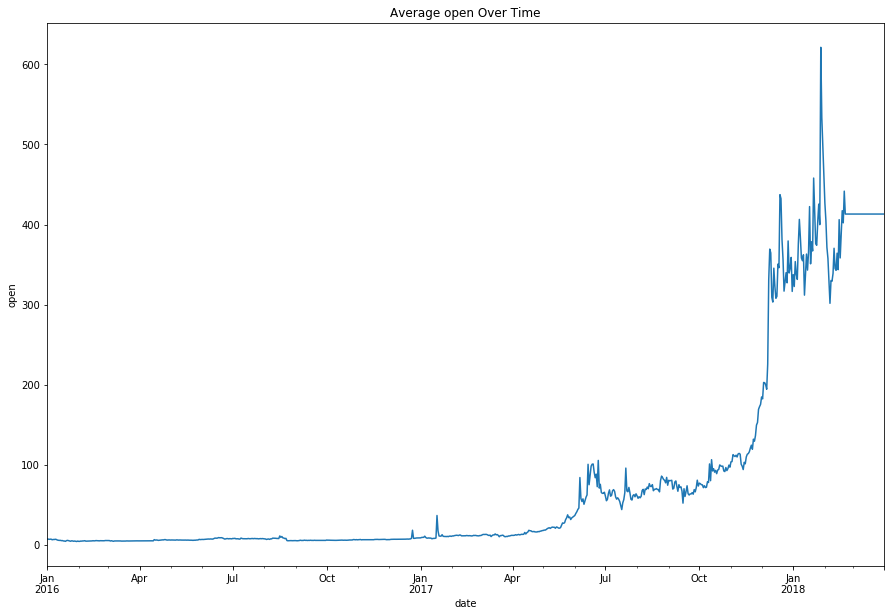

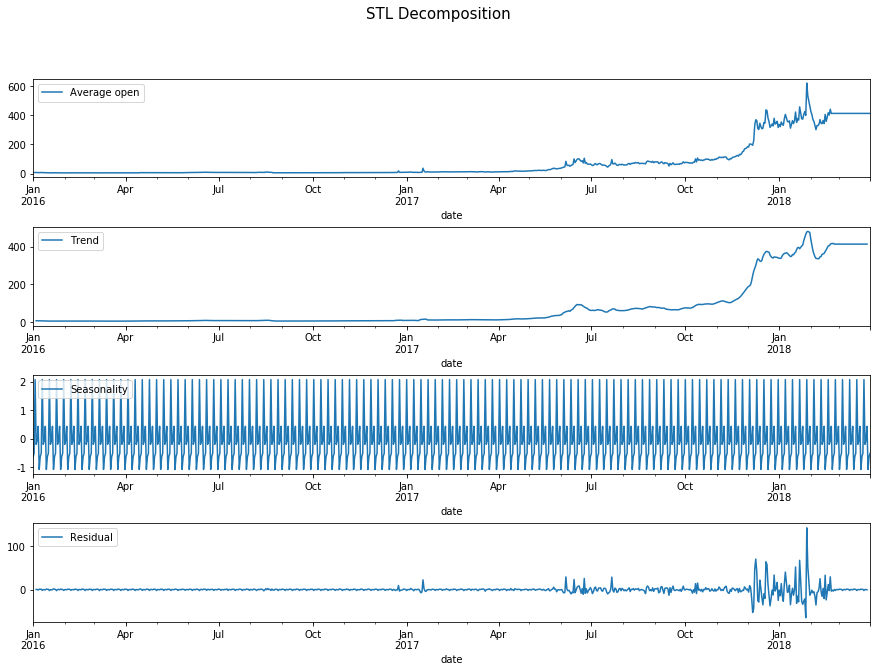

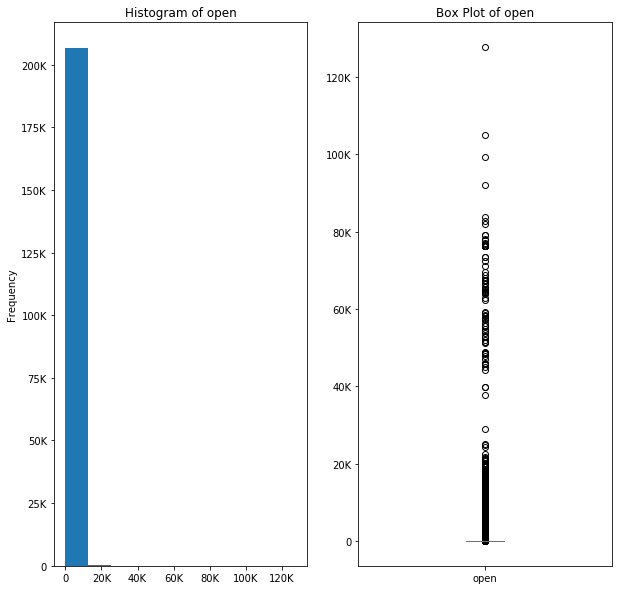

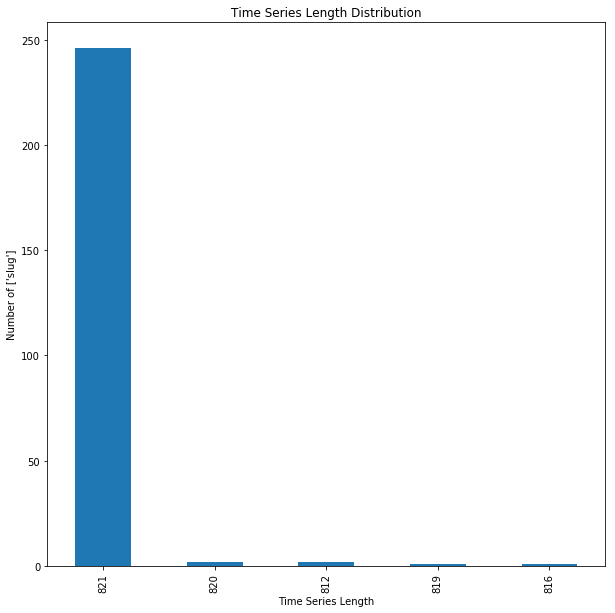

In [47]:
imputed_ts.ts_summary()

### END OF LAB

---

Now, all time series are regular with mostly daily frequencies, though there are still currencies for which that's not the case.

## Feature Engineering

### Create and Test Data Transformers
**Note**: Currently, we only use univariate time series models. Therefore, the transfomers are created and tested for
demonstration purpose only. 

In [48]:
# Create transformers
rolling_transformer = RollingWindow(window_size=3, transform_dict={'mean': ['open', 'close']})
lag_transformer = LagOperator(lags_to_construct=3, columns_to_lag='open')

# check transformer output
transformed_ts = rolling_transformer.transform(imputed_ts)
transformed_ts = lag_transformer.transform(transformed_ts)

In [49]:
transformed_ts.loc[idx[:, 'bitcoin'], :].head()

,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,dow,open_mean_window3,close_mean_window3,open_lag3
date,slug,,,,,,,,,,,,,,,
2016-01-01,bitcoin,BTC,Bitcoin,1.00,430.72,436.25,427.51,434.33,36278900.00,6473530000.00,0.78,8.74,4,nan,nan,nan
2016-01-02,bitcoin,BTC,Bitcoin,1.00,434.62,436.06,431.87,433.44,30096600.00,6533630000.00,0.37,4.19,5,nan,nan,nan
2016-01-03,bitcoin,BTC,Bitcoin,1.00,433.58,433.74,424.71,430.01,39633800.00,6519500000.00,0.59,9.03,6,432.97,432.59,nan
2016-01-04,bitcoin,BTC,Bitcoin,1.00,430.06,434.52,429.08,433.09,38477500.00,6468180000.00,0.74,5.44,0,432.75,432.18,430.72
2016-01-05,bitcoin,BTC,Bitcoin,1.00,433.07,434.18,429.68,431.96,34522600.00,6515380000.00,0.51,4.50,1,432.24,431.69,434.62


## Model Training and Validation

We are now ready to begin our modeling, and we do so by first splitting the data into a training, a validation set used for model selection, and a test set used to give us an unbiased error estimate. With time series data, since we are trying to predict the "future", we want the split to occur not randomly but based on some cut-off date.

In [232]:
cutoff_dt = '2017-06-30'
val_cutoff_dt = '2017-05-01'

train_ts = transformed_ts.loc[transformed_ts.time_index < val_cutoff_dt]
validate_ts = transformed_ts.loc[(transformed_ts.time_index >= val_cutoff_dt) & (transformed_ts.time_index <= cutoff_dt)]
test_ts = transformed_ts.loc[transformed_ts.time_index > cutoff_dt]

In [233]:
assert (len(train_ts) > 1000) & (len(validate_ts) > 1000) & (len(test_ts) > 1000)

### Initialize Models

Based on the inferred frequency and seasonality, we set the following model parameters. 

In [360]:
# Model parameters
series_freq = 'D'
series_seasonality = 7

We try three different models here: a naive model which will serve as our baseline, a seasonal naive model, and finally an Arima model.

In [361]:
# Initialize naive model
naive_model = Naive(freq = series_freq)

# Initialize seasonal naive model
seasonal_naive_model = SeasonalNaive(freq = series_freq, seasonality = series_seasonality)

# Initialize ARIMA(p,d,q) model
arima_order = [2, 2, 0]
arima_model = Arima(series_freq, arima_order)

### Build the Pipelines

To train a model, we create a pipeline. Once the model is trained, we can use the same pipeline to score (run forecasts on) the validation and test data.

In [362]:
pipeline_naive = AzureMLForecastPipeline([('naive_model', naive_model)])
pipeline_seasonal_naive = AzureMLForecastPipeline([('seasonal_naive_model', seasonal_naive_model)])
pipeline_arima = AzureMLForecastPipeline([('arima_model', arima_model)])

### Fit the Pipelines

By calling the `fit` method of the pipeline and passing the training data, we can train the model.

In [363]:
pipeline_naive = pipeline_naive.fit(train_ts)
pipeline_seasonal_naive = pipeline_seasonal_naive.fit(train_ts)
pipeline_arima = pipeline_arima.fit(train_ts)

F1 2018-04-21 20:23:57,363 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-21 20:23:59,635 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:02.272387
F1 2018-04-21 20:23:59,651 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-21 20:24:01,824 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:02.173111
F1 2018-04-21 20:24:01,839 INFO azureml.timeseries - pipeline fit started. 


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sethm

F1 2018-04-21 20:24:31,327 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:29.487453


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Predict and Evaluate Model Performances

Once we have a trained model, we score the validation data and then call the `calc_error` method to obtain error estimates for the models we chose to compare. This allows us to see which model performs better.

In [364]:
validate_predicted_naive = pipeline_naive.predict(validate_ts)
validate_predicted_seasonal_naive = pipeline_seasonal_naive.predict(validate_ts)
validate_predicted_arima = pipeline_arima.predict(validate_ts)

validate_error_naive = validate_predicted_naive.calc_error()
validate_error_seasonal_naive = validate_predicted_seasonal_naive.calc_error()
validate_error_arima = validate_predicted_arima.calc_error()

print('Naive model MAPE: {0}'.format(validate_error_naive))
print('Seasonal naive model MAPE: {0}'.format(validate_error_seasonal_naive))
print('ARIMA model MAPE: {0}'.format(validate_error_arima))

F1 2018-04-21 20:24:31,358 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-21 20:24:45,945 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:14.587322
F1 2018-04-21 20:24:46,130 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-21 20:29:14,683 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:04:28.537202
F1 2018-04-21 20:29:15,052 INFO azureml.timeseries - pipeline predict started. 


C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


F1 2018-04-21 20:29:39,088 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:24.036430
Naive model MAPE: 73.93695890150178
Seasonal naive model MAPE: 59.74402084108584
ARIMA model MAPE: 825.0942461255896


Once we've tested different models and compared their accuracy, it's time to settle for one or a few good models.

The model evaluation results above show that the Naive model outperforms the other two. So we combine the training and validation data and re-fit the Naive model (so we can have a more accurate estimate) and score the trained model on the test data to obtain an unbiased measure of the model's error. Finally, we dump the opening price and the forecast for opening price into a data set we call `pred_ts`.

In [365]:
# chosen_model = pipeline_arima
# pred_var = 'PointForecastArima'

# chosen_model = pipeline_naive
# pred_var = 'PointForecastNaive'

chosen_model = pipeline_seasonal_naive
pred_var = 'PointForecastSeasonalNaive'

chosen_model.fit(pd.concat([train_ts, validate_ts]))
pred_ts = chosen_model.predict(test_ts)
pred_ts.head()

F1 2018-04-21 20:29:40,189 INFO azureml.timeseries - pipeline fit started. 
F1 2018-04-21 20:29:43,332 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:03.142353
F1 2018-04-21 20:29:43,332 INFO azureml.timeseries - pipeline predict started. 
F1 2018-04-21 20:30:49,495 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:01:06.162858


,,,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,dow,open_mean_window3,close_mean_window3,open_lag3,DistributionForecastSeasonalNaive,PointForecastSeasonalNaive
date,slug,ForecastOriginDate,,,,,,,,,,,,,,,,,
2017-07-01,1337coin,2017-06-30,1337,Elite,501.00,0.00,0.00,0.00,0.00,13983.00,2321510.00,0.58,0.00,5,0.00,0.00,0.00,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00
2017-07-02,1337coin,2017-06-30,1337,Elite,501.00,0.00,0.00,0.00,0.00,4348.00,2127030.00,0.84,0.00,6,0.00,0.00,0.00,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00
2017-07-03,1337coin,2017-06-30,1337,Elite,501.00,0.00,0.00,0.00,0.00,11246.00,2198620.00,0.65,0.00,0,0.00,0.00,0.00,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00
2017-07-04,1337coin,2017-06-30,1337,Elite,501.00,0.00,0.00,0.00,0.00,7304.00,2183890.00,0.64,0.00,1,0.00,0.00,0.00,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00
2017-07-05,1337coin,2017-06-30,1337,Elite,501.00,0.00,0.00,0.00,0.00,61345.00,2189890.00,0.96,0.00,2,0.00,0.00,0.00,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00


## LAB 7

Run basic (5-point) summary to compare the predictions to the actual (observed) values for opening price on the test data, grouped by the currency.

In [366]:
diff = pred_ts['open'] - pred_ts[pred_var]
diff = diff.groupby(pred_ts.index.get_level_values(1)).describe()

Sort the above results by the absolute value of the median forecast error.

In [367]:
diff = diff.assign(abs_err = np.abs(diff['50%'])).sort_values('abs_err', ascending = False).drop('abs_err', axis = 1)
diff.head()

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
bitbtc,274.00,6349.58,5175.28,-430.50,1578.39,5265.12,10810.49,18642.65
bitcoin,274.00,5515.10,4482.92,-657.95,1602.03,4776.48,8815.54,16868.55
42-coin,274.00,22051.97,29715.90,-12348.37,-1812.61,1734.57,52532.55,116156.30
dash,274.00,352.04,310.63,-42.70,112.35,242.31,515.61,1372.42
monero,274.00,140.58,122.82,-16.43,41.19,84.88,256.49,423.25


We can now run some plots for bottom 3 and top 3 currencies (in terms of model accuracy).

In [368]:
cats_to_keep = list(diff.index.values[:3]) + list(diff.index.values[-3:])
cats_to_keep

['bitbtc', 'bitcoin', '42-coin', 'bunnycoin', 'pandacoin-pnd', 'paccoin']

In [369]:
diff.loc[cats_to_keep, :]

,count,mean,std,min,25%,50%,75%,max
slug,,,,,,,,
bitbtc,274.00,6349.58,5175.28,-430.50,1578.39,5265.12,10810.49,18642.65
bitcoin,274.00,5515.10,4482.92,-657.95,1602.03,4776.48,8815.54,16868.55
42-coin,274.00,22051.97,29715.90,-12348.37,-1812.61,1734.57,52532.55,116156.30
bunnycoin,274.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
pandacoin-pnd,274.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
paccoin,274.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00


We can collect the data for the top three and bottom three currencies.

In [370]:
pred_ts.sort_index(inplace = True)
ax = pred_ts.loc[idx[:, cats_to_keep, :], :].reset_index(level = 2)

With some rearranging, we can create a line plot for each currency showing the opening price and its forecast over time.

In [371]:
bla = ax.groupby(level=[0, 1])[['open', pred_var]].mean().unstack()
bla.head()

open                                                  \
slug        42-coin  bitbtc bitcoin bunnycoin paccoin pandacoin-pnd   
date                                                                  
2017-07-01  9183.86 2531.24 2492.60      0.00    0.00          0.00   
2017-07-02  7952.36 2466.84 2436.40      0.00    0.00          0.00   
2017-07-03  8527.48 2295.62 2498.56      0.00    0.00          0.00   
2017-07-04 10018.00 2572.61 2561.00      0.00    0.00          0.00   
2017-07-05 11019.30 2561.74 2602.87      0.00    0.00          0.00   

           PointForecastSeasonalNaive                                    \
slug                          42-coin  bitbtc bitcoin bunnycoin paccoin   
date                                                                      
2017-07-01                   19882.10 2766.89 2738.52      0.00    0.00   
2017-07-02                   11582.70 2507.45 2607.25      0.00    0.00   
2017-07-03                   12674.00 2583.70 2590.57      0.00    0.00   
2017-07-04                   10371.80 2516.16 2478.45      0.00    0.00   
2017-07-05                    9950.45 2533.11 2553.03      0.00    0.00   

                          
slug       pandacoin-pnd  
date                      
2017-07-01          0.00  
2017-07-02          0.00  
2017-07-03          0.00  
2017-07-04          0.00  
2017-07-05          0.00

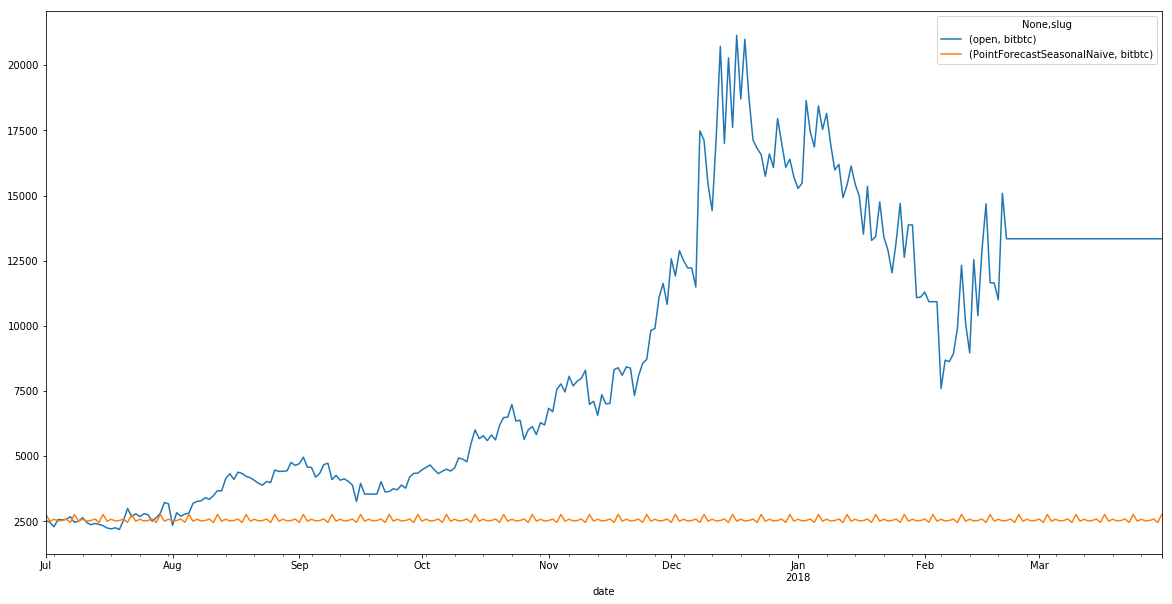

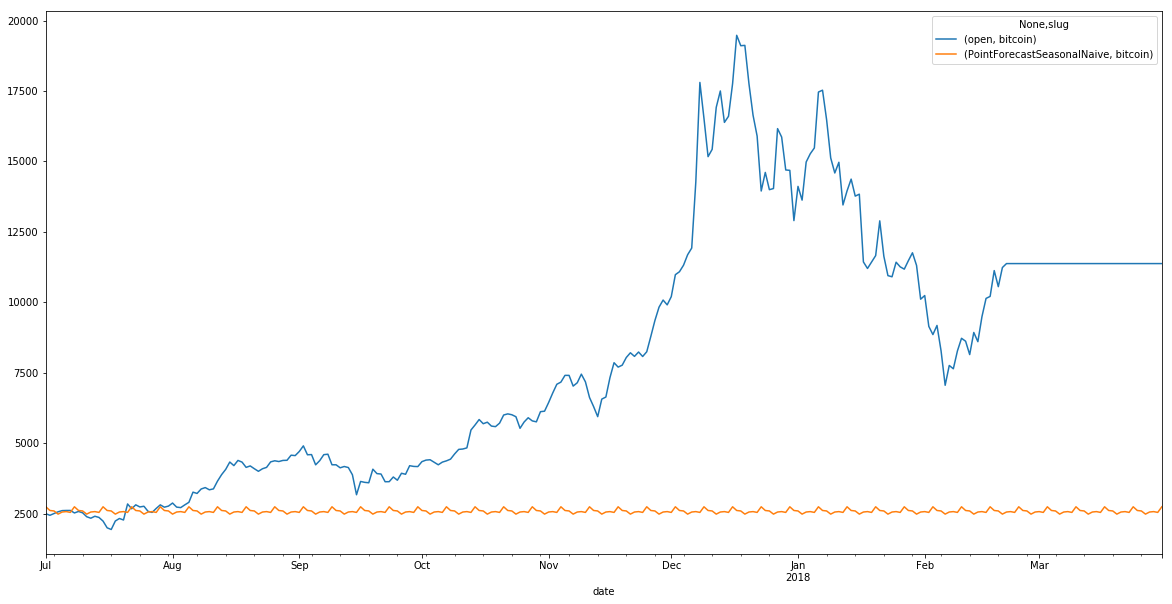

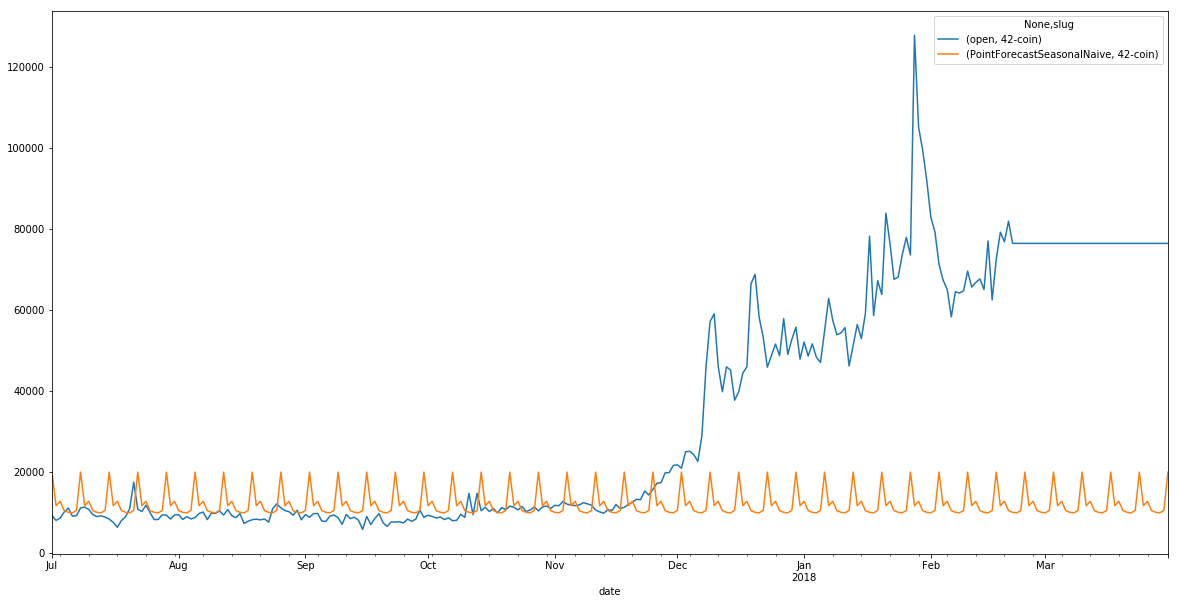

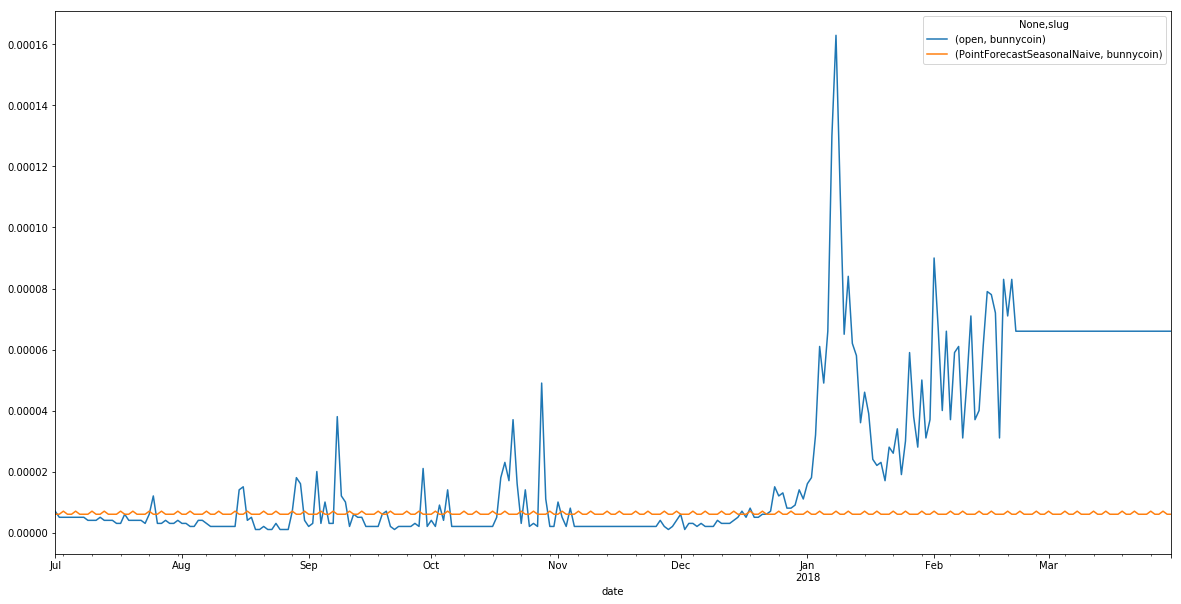

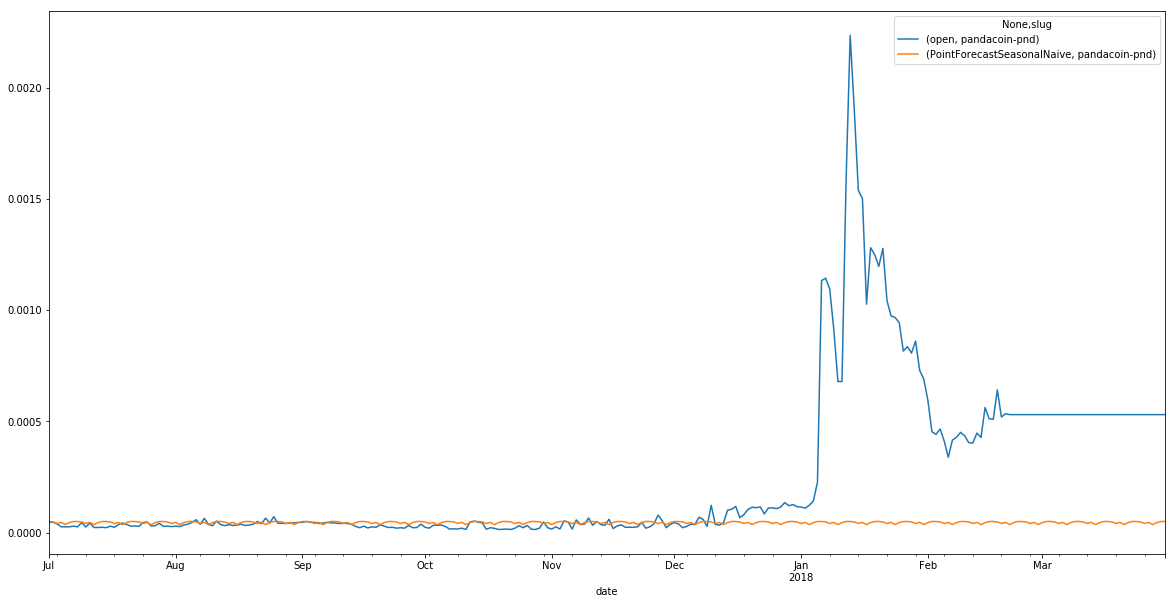

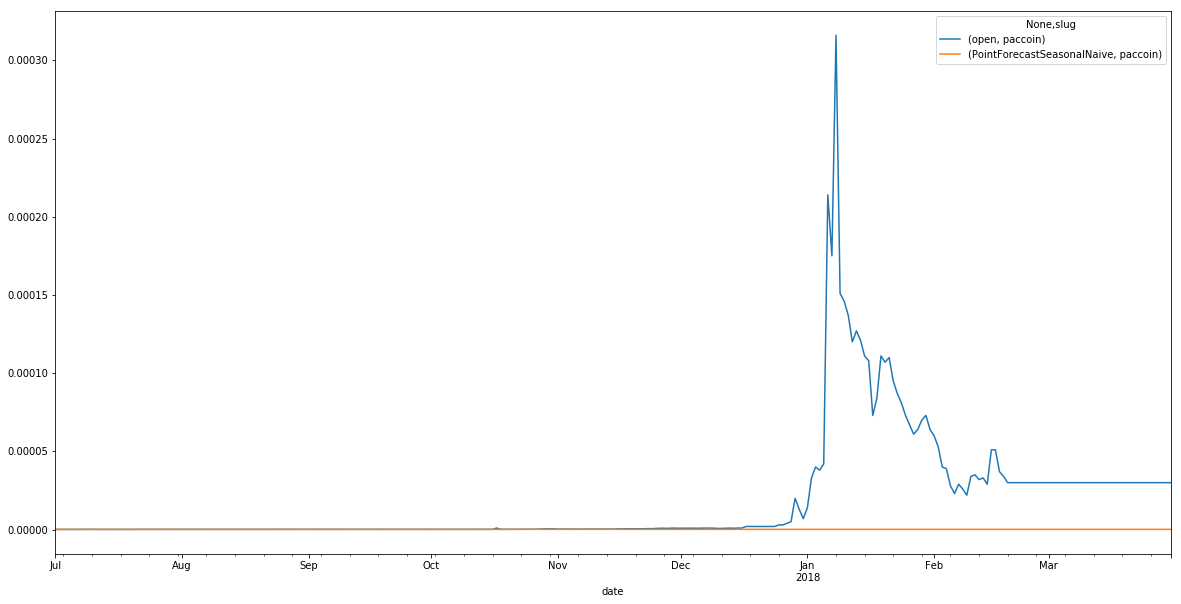

In [372]:
for currency in cats_to_keep:
    plt = bla.loc[:, (slice(None), currency)].plot()

### END OF LAB

---

# Operationalization
In this section, we will deploy a pipeline as a Azure Machine Learning web service and use it for training and scoring using AML's Python SDK.

Currently, the following two workflows are available:
1. Deploy a pipeline that's not fitted as a web service. Call the web service to do both training and scoring.
2. Deploy a fitted pipeline. Call the web service to score only.

### Set model deployment parameters
Please change the following parameters to your own values. Make sure your AML environment, model management account, and resource group are located in the same region. 

In [ ]:
azure_subscription = '5be49961-ea44-42ec-8021-b728be90d58c'

# If cluster is True, create a Azure Container Service cluster and deploy the web service there.
# If False, deploy the "web service" locally.
# Cluste deployment takes about 20 minutes and local takes about 5 minutes. 
cluster = False

# The AML environment name. This could be an existing AML environment or a new AML environment to be created automatically.
aml_env_name = 'cryptocurrencyenv'

# The resource group that contains the Azure resources related to the AML environment.
aml_env_resource_group = 'sethmottftktest'

# The location where the Azure resources related to the AML environment are located at.
aml_env_location = 'westcentralus'

# The AML model management account name. This could be an existing model management account a new model management 
# account to be created automatically. 
model_management_account_name = 'sethmottmlmm'

# The resource group that contains the Azure resources related to the model management account.
model_management_account_resource_group = 'sethmottbc'

# The location where the Azure resources related to the model management account are located at.
model_management_account_location = 'eastus2'

# The name of the deployment/web service.
deployment_name = 'sethmottftkserv'

# The directory to store deployment related files, such as pipeline pickle file, score script, and conda dependencies file. 
deployment_working_directory = 'C:\\Users\\sethmott\\ftk'

### Define the AML environment and deployment

In [ ]:
aml_env = AMLEnvironment(env_name=aml_env_name, 
                         env_resource_group=aml_env_resource_group,
                         env_location=aml_env_location, 
                         azure_subscription=azure_subscription,
                         model_management_account_name=model_management_account_name, 
                         model_management_account_resource_group=model_management_account_resource_group,
                         model_management_account_location=model_management_account_location,
                         cluster=cluster)

snaive_model = SeasonalNaive(freq=series_freq, seasonality=series_seasonality)
pipeline_snaive = AzureMLForecastPipeline([('seasonal_naive_model', snaive_model)])
aml_deployment = AMLDeployment(aml_env=aml_env, 
                               deployment_name=deployment_name,
                               pipeline=pipeline_snaive,
                               deployment_working_directory=deployment_working_directory)

### Create the web service

In [ ]:
# This step can take 5 to 20 minutes
# NOTE: Currently, recreate=False is not supported for deploying to ACS clusters
aml_deployment.deploy()

### Score and evaluate web service
To score a small dataset, use the score method to submit one web service call for all the data. 

In [ ]:
# Need to add empty prediction columns to the validation data frame 
# and create a ForecastDataFram
validate_ts = validate_ts.assign(SeasonalNaivePointForecast=0.0,
                                 SeasonalNaiveDistributionForecast=np.nan)
validate_fcst = ForecastDataFrame(validate_ts, pred_point='SeasonalNaivePointForecast',
                                 pred_dist='SeasonalNaiveDistributionForecast')

# Define Score Context
# This is for deploying a pipeline not fitted yet.
score_context = ScoreContext(input_training_data_tsdf=train_ts, 
                             input_scoring_data_fcdf=validate_fcst, 
                             pipeline_execution_type='train_predict')

# If deploying a fitted pipeline use the following score_context
# score_context = ScoreContext(input_scoring_data_fcdf=input_scoring_data_df, 
#                             pipeline_execution_type='predict_only') 

# Get deployed web service
aml_web_service = aml_deployment.get_deployment()

# Score the web service
results = aml_web_service.score(score_context=score_context)
print(type(results))
print(results)

# Evaluate result
webservice_error = results.calc_error()
print('Seasonal naive model MAPE:{0}'.format(webservice_error))

To score a large dataset, use the score_driver method to submit multiple web service calls, one for each unique value of
group_col. 

In [ ]:
# Call the forecast service once for each store in the validation set
results = aml_web_service.score_driver(score_context=score_context, group_col='Store')

# Calculate the forecasting errors for store time series
webservice_fcst_errors = results.calc_error(by='Store')
webservice_fcst_errors